In [1]:
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
import gc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from scipy.signal import medfilt
sns.set(font_scale=0)
%matplotlib inline

In [2]:
def ShowImage(img, isGrey = False):
    plt.figure(figsize=(20, 15))
    if not isGrey:
        plt.imshow(img, interpolation='nearest')
    else:
        plt.imshow(img, cmap='gray')
    plt.axis('off')
    gc.collect()

# Алгоритм Бредли

ссылка на алгоритм - http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.420.7883&rep=rep1&type=pdf

Преобразование в изображение в серых тонах - https://en.wikipedia.org/wiki/YUV

Данный алгоритм был выбран мной, так как он дает хорошую биноризацию изображения, при этом работает очень быстро (на C++). 

Все константы изначально были взяты из оригинальной статьи, но поэксперементировав с `t_proc` (в статье просто t), я изменил константу с оригинальной 0.85 на 0.9 (в данном ноутбуке оставлена константа 0.85, в итоговых избражениях порог взят 0.9 (были получены из кода на c++)). Разница в улучшении больше всего заметна на фотографии с задней стороной книги (4 пример). Результаты времени работы, а также общие соображения по результатам будут описаны в конце.

In [4]:
def create_grey_image(image, red_coeff = 0.299, green_coeff = 0.587):
    xr = np.copy(image[:,:,0])
    xg = np.copy(image[:,:,1])
    xb = np.copy(image[:,:,2])
    I = red_coeff * xr + green_coeff * xg + (1 - green_coeff - red_coeff) * xb
    #I = medfilt(I, 3)
    return I

In [5]:
def intagrate_image(f):
    I = f.copy()
    N = I.shape[0]
    M = I.shape[1]
    for i in range(1, N):
        for j in range(1, M):
            I[i][j] = I[i][j] + I[i - 1][j] + I[i][j - 1] - I[i - 1][j - 1]
    return I

In [6]:
def make_answer(I, F, t_proc = 0.85, s = None):
    N = I.shape[0]
    M = I.shape[1]
    if s is None:
        dh = 1 / 8 * N
        dw = 1 / 8 * M
        s = int(min(dh, dw) // 2)
    answer = np.zeros((N, M))
    for i in range(0, N, 1):
        for j in range(0, M, 1):
            imax = int(min(i + s, N - 1))
            jmax = int(min(j + s, M - 1))
            imin = int(max(i - s, 0))
            jmin = int(max(j - s, 0))
            size = (imax - imin) * (jmax - jmin)
            summ = I[imax, jmax]
            if imin >= 1:
                summ -= I[imin - 1, jmax]
            if jmin >= 1:
                summ -= I[imax, jmin - 1]
            if jmin >= 1 and imin >= 1:
                summ += I[imin - 1, jmin - 1]
            if F[i][j] >= (summ / size) * t_proc:
                answer[i][j] = 255
    return answer

In [33]:
def Get_Bradley_Binorization(number, image, red_coeff = 0.299, green_coeff = 0.587, t_proc = 0.85, s = None):
    F = create_grey_image(image, red_coeff, green_coeff)
    print(F[100, 100])
    I = intagrate_image(F)
    print(I[100, 100])
    answer = make_answer(I, F, t_proc, s)
    plt.imsave("Result/bradley_" + i + ".png", answer, cmap='gray')
    return answer

100%|██████████| 15/15 [24:03<00:00, 102.71s/it]


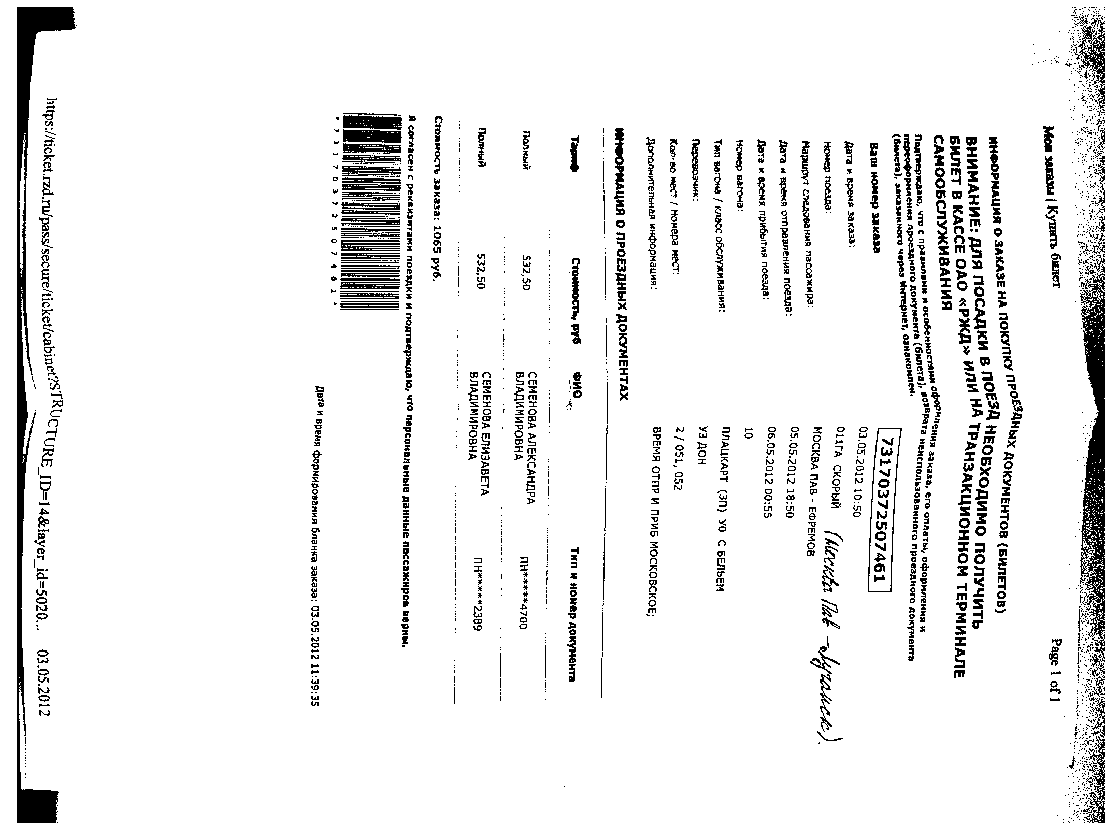

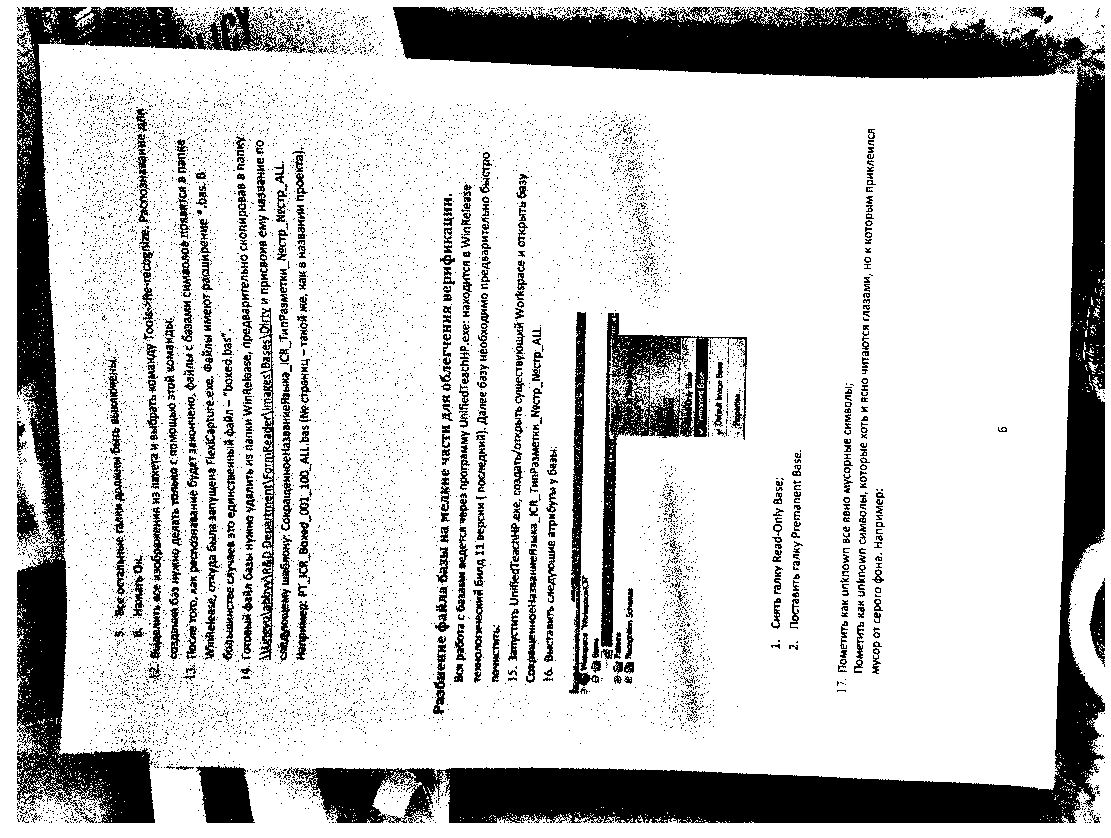

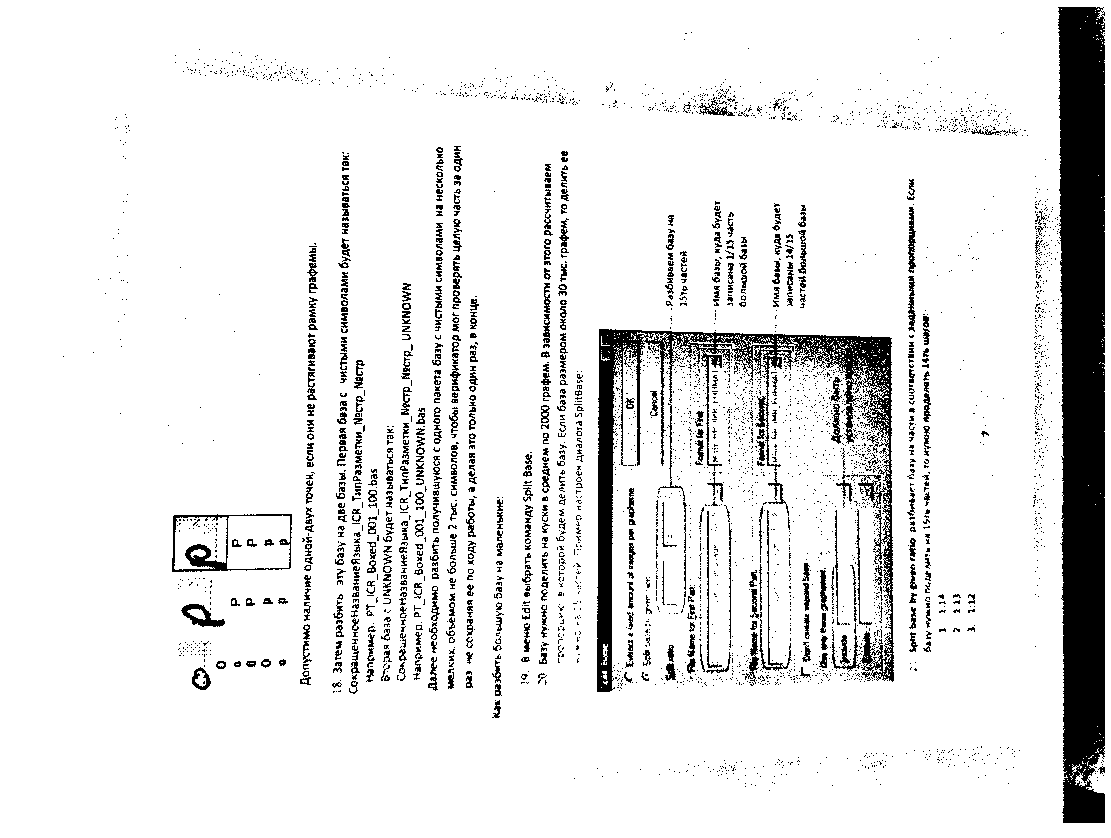

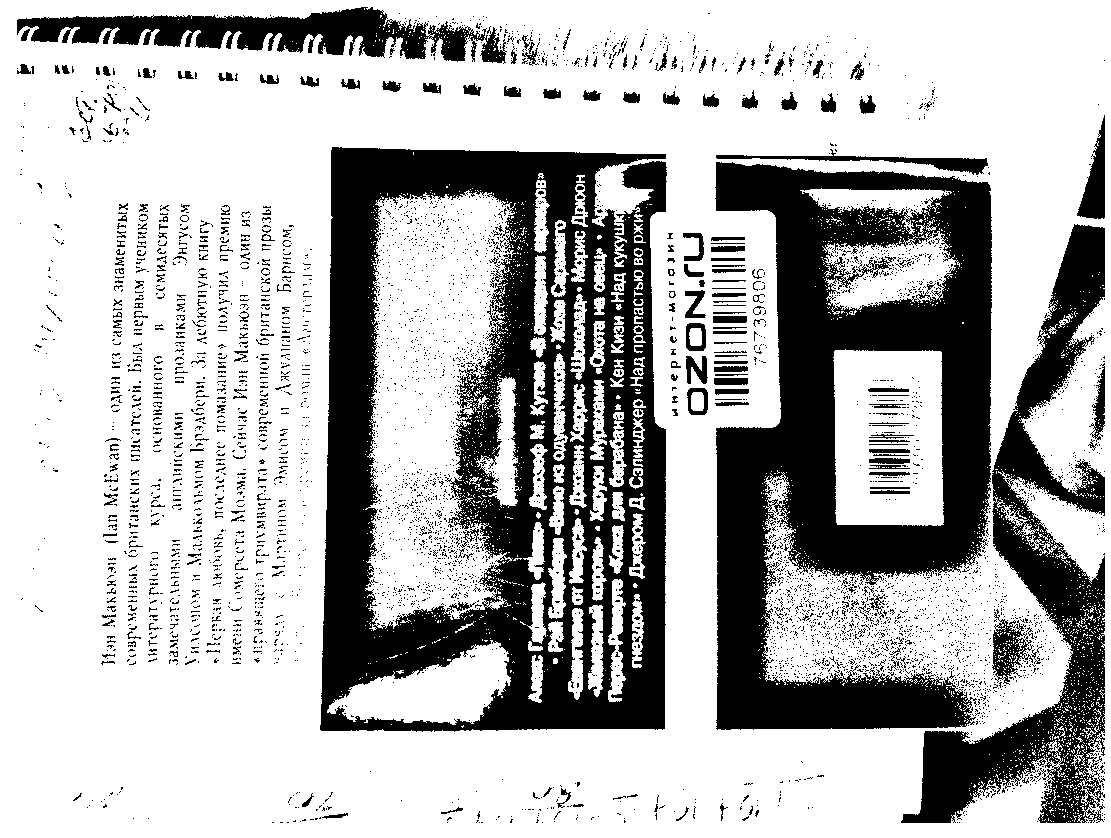

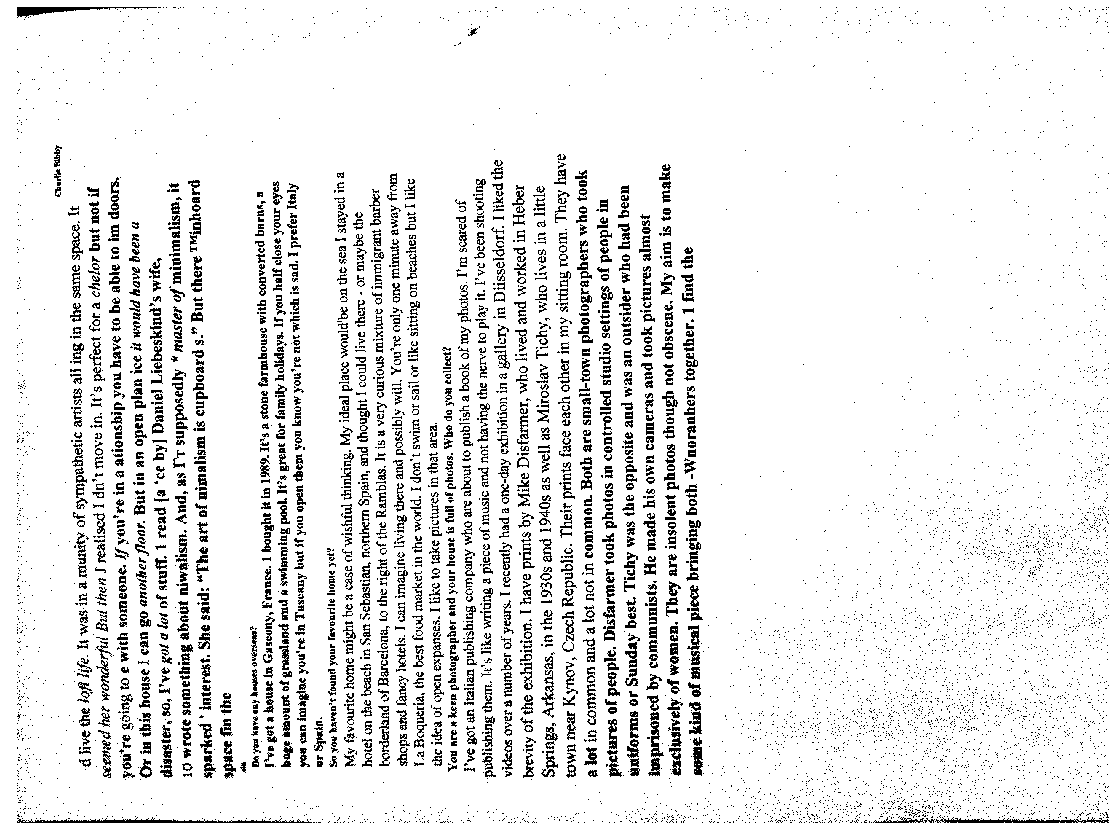

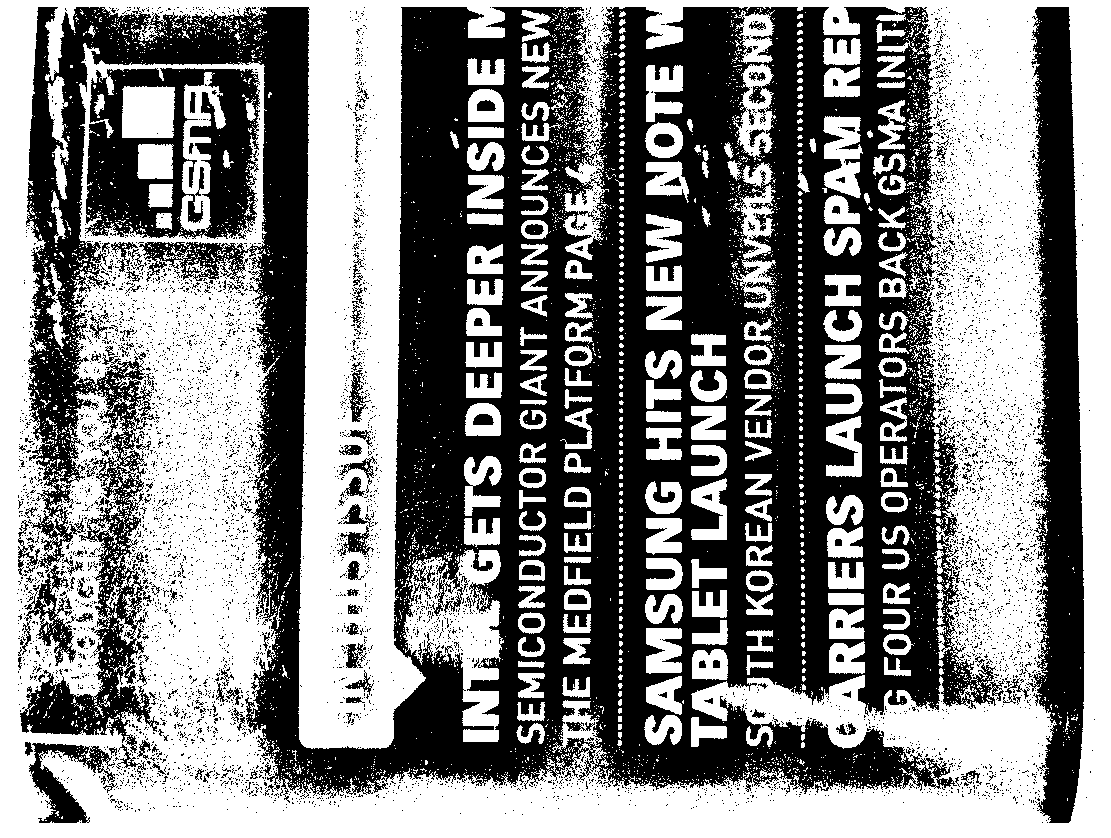

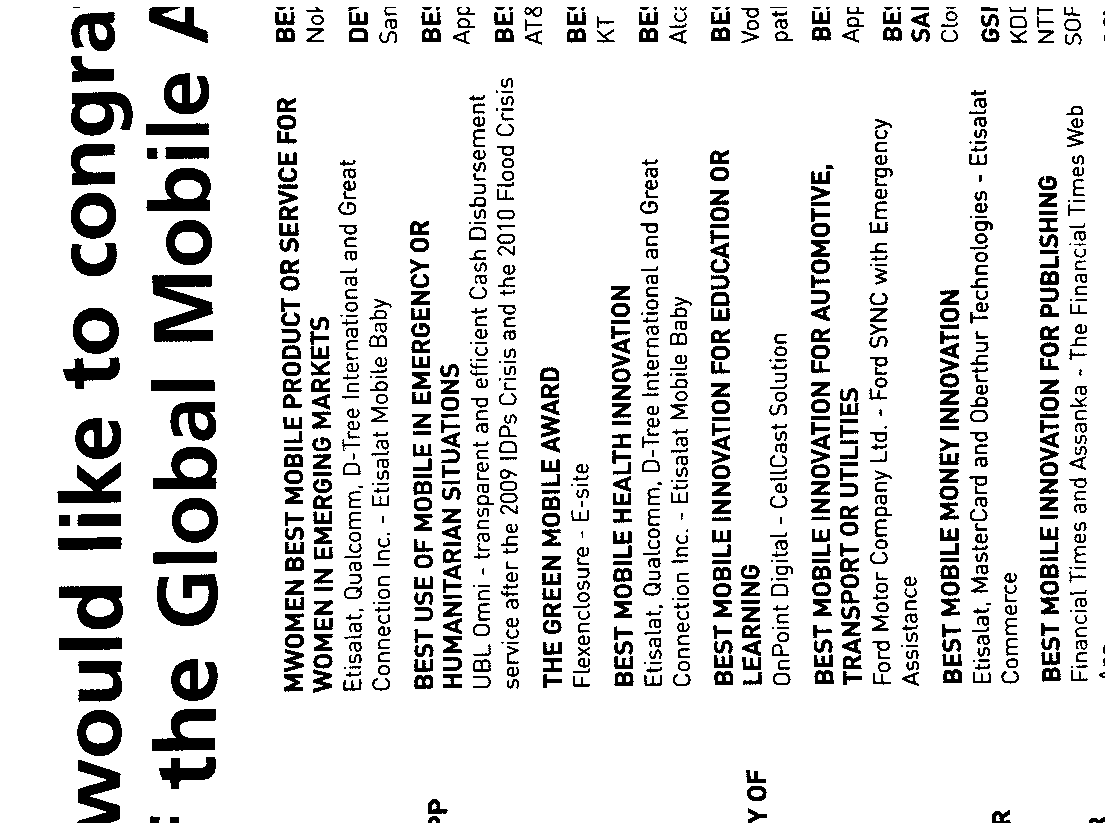

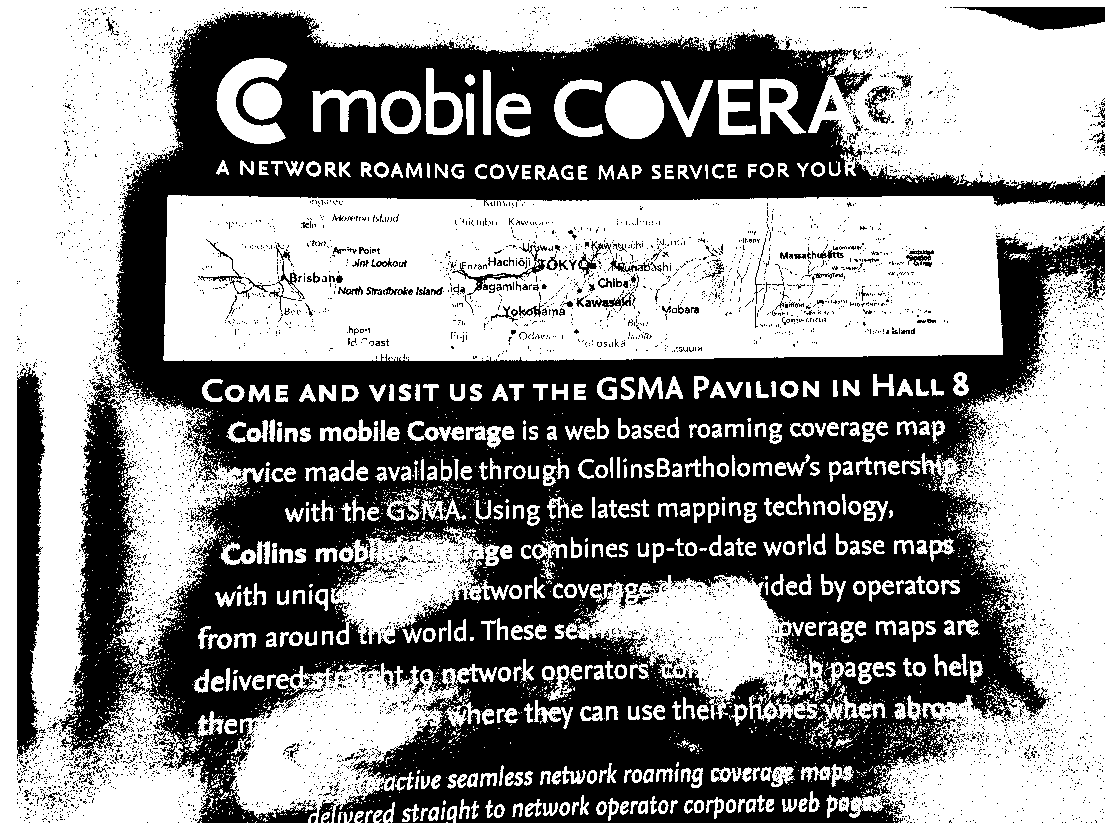

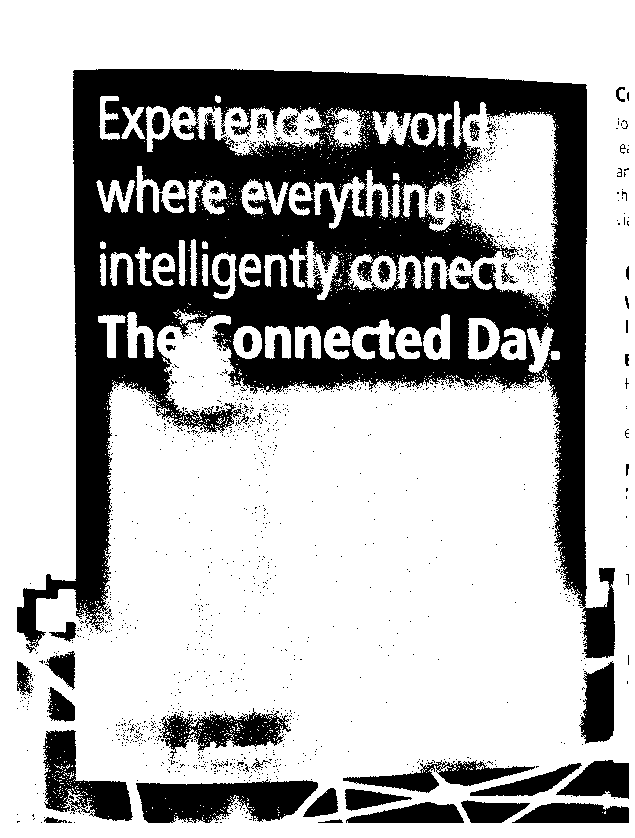

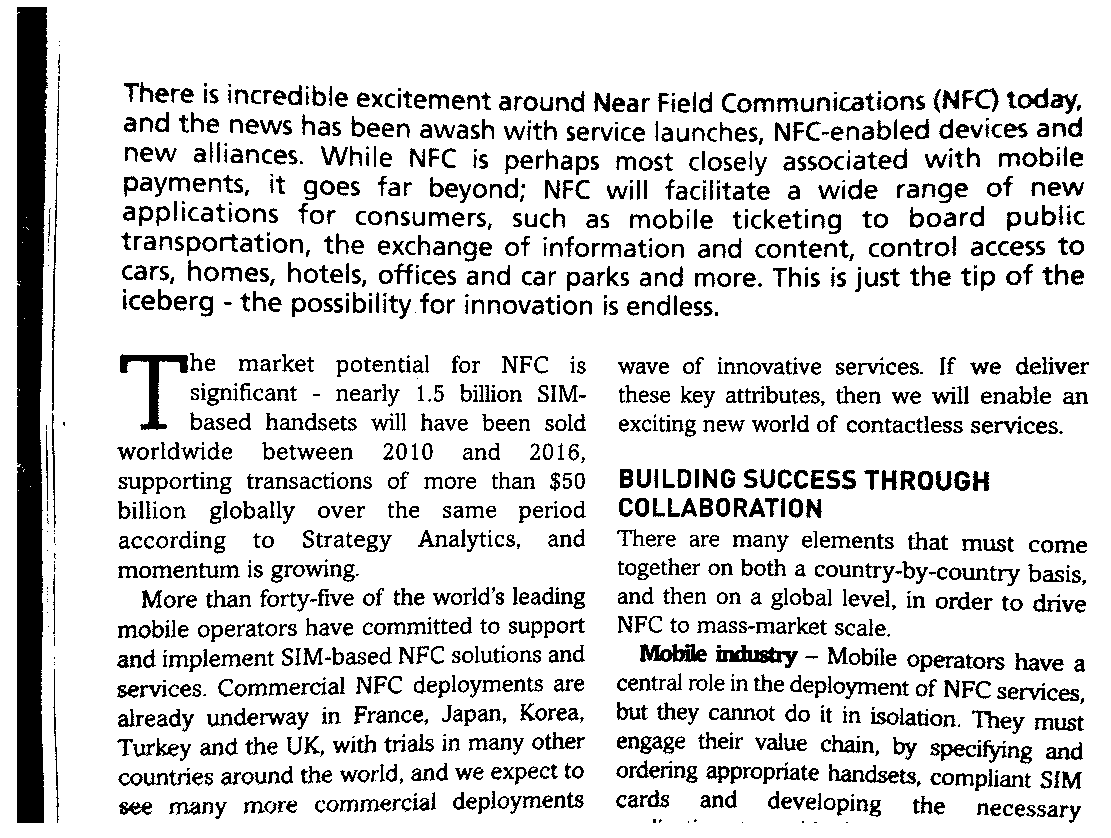

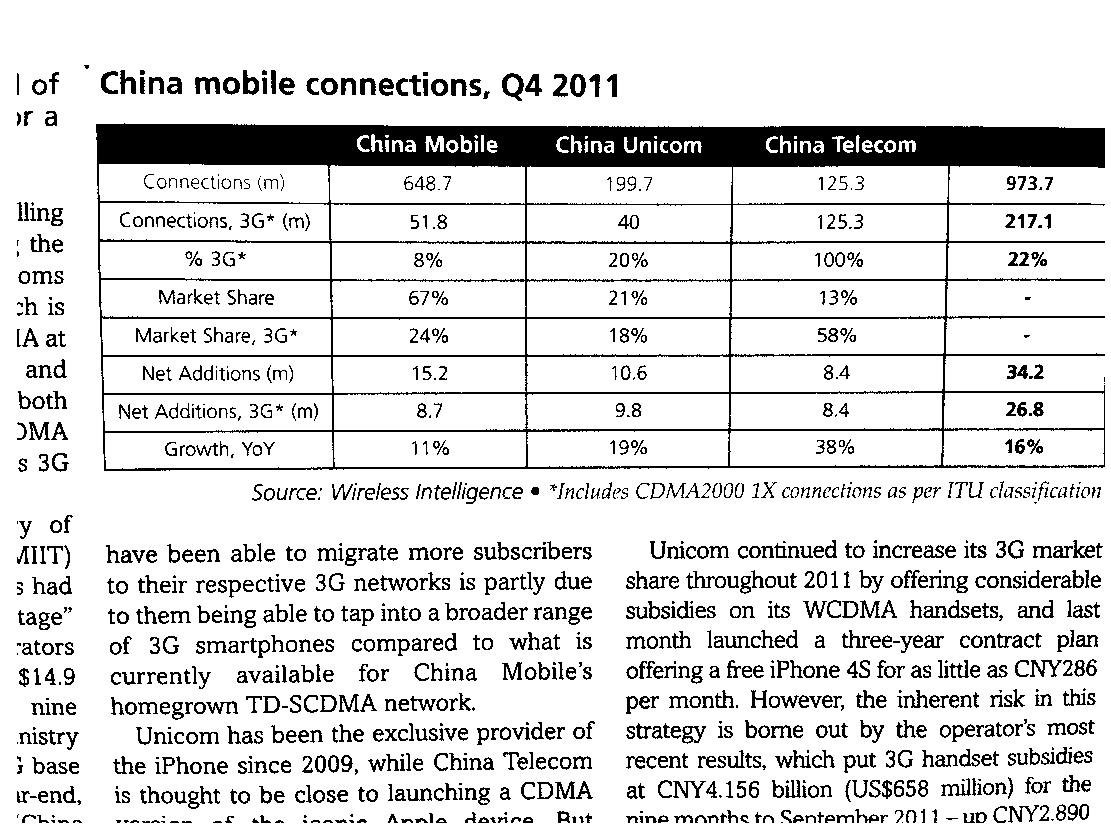

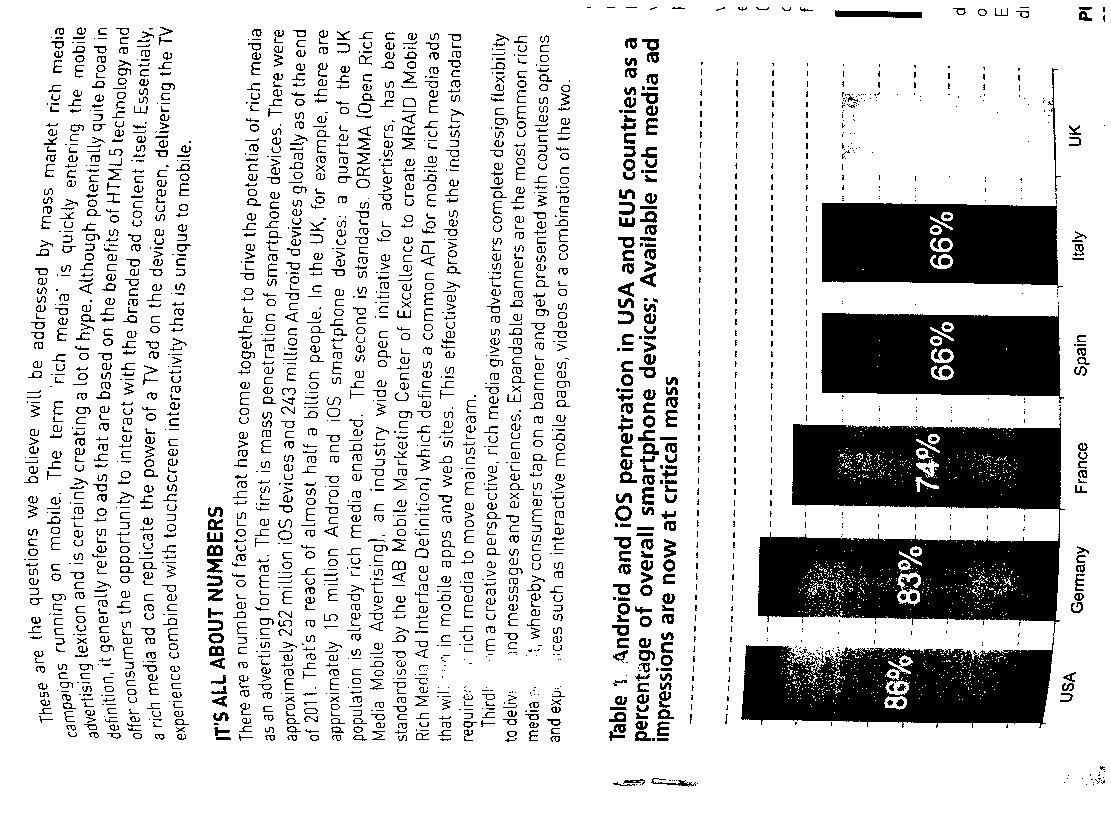

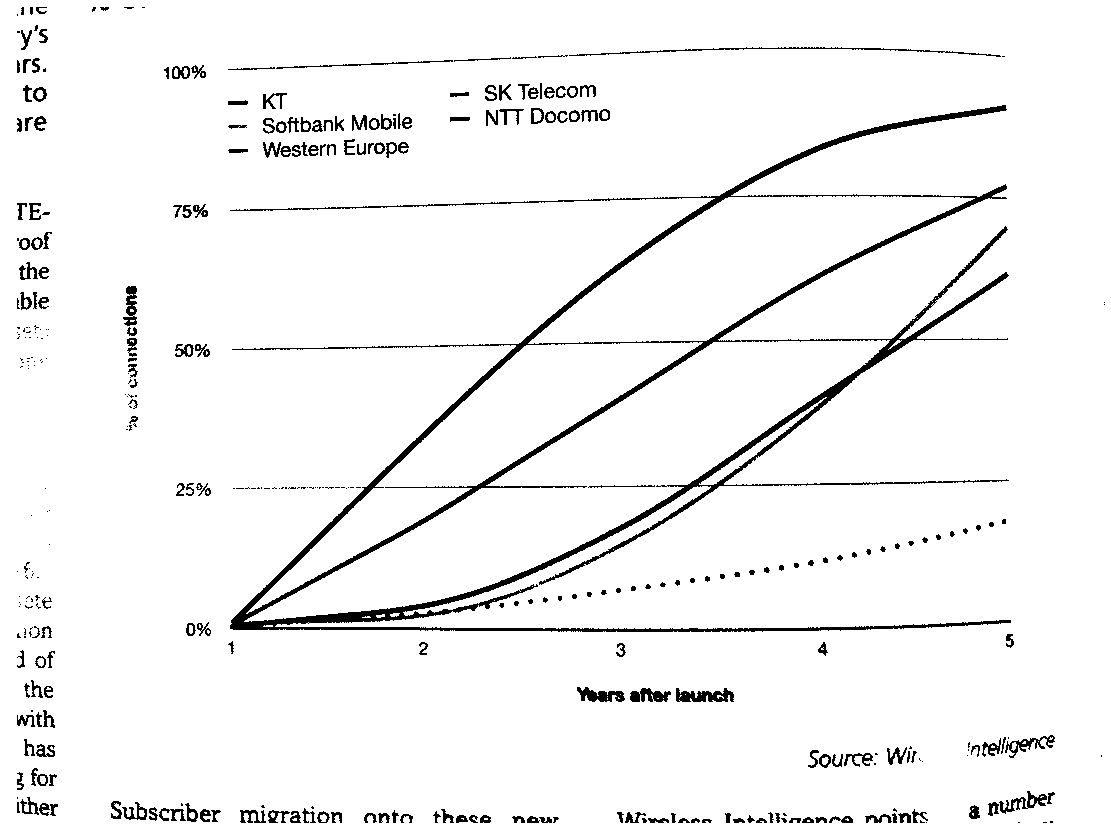

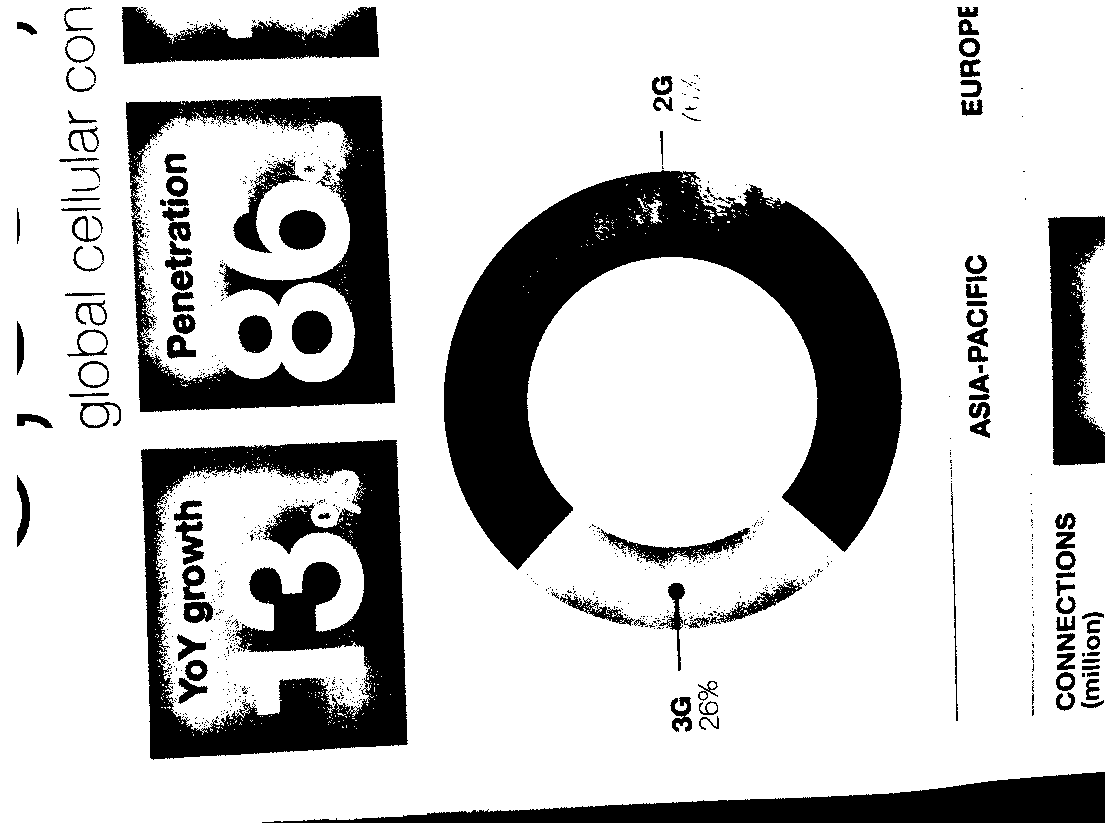

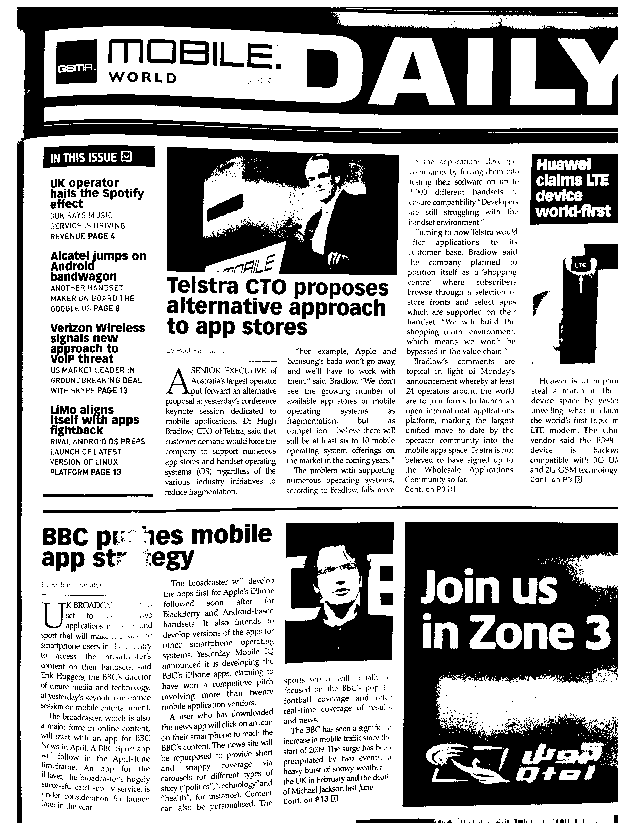

In [19]:
for i in tqdm(["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15"]):
    path = 'Dataset/' + i + '.JPG'
    image = plt.imread(path)
    image = image / 255
    answer = Get_Bradley_Binorization(i, image)
    ShowImage(answer, True)

## Время работы

Время Работы кода на С++:

image: Dataset/01.JPG - sec/megapixel: 0.180898

image: Dataset/02.JPG - sec/megapixel: 0.181851

image: Dataset/03.JPG - sec/megapixel: 0.182748

image: Dataset/04.JPG - sec/megapixel: 0.180665

image: Dataset/05.JPG - sec/megapixel: 0.182378

image: Dataset/06.JPG - sec/megapixel: 0.180547

image: Dataset/07.JPG - sec/megapixel: 0.180336

image: Dataset/08.JPG - sec/megapixel: 0.184976

image: Dataset/09.JPG - sec/megapixel: 0.182872

image: Dataset/10.JPG - sec/megapixel: 0.189801

image: Dataset/11.JPG - sec/megapixel: 0.183123

image: Dataset/12.JPG - sec/megapixel: 0.182579

image: Dataset/13.JPG - sec/megapixel: 0.189904

image: Dataset/14.JPG - sec/megapixel: 0.182623

image: Dataset/15.JPG - sec/megapixel: 0.180961

In [41]:
times = np.array([0.181851, 0.182748, 0.180665, 0.182378, 0.182378, 0.180547, 0.180336, 0.184976, 0.182872, 0.189801, \
         0.183123, 0.182579, 0.189904, 0.182623, 0.182623])

In [42]:
len(times)

15

In [43]:
np.mean(times)

0.18329359999999997

Среднее время работы - 0.1833 сек.мегапиксель, что во много раз быстрее, чем на питоне. (Код на питоне обрабатывал 15 фото 24 минуты, то есть больше минуты на фото, а если учесть, что в тестовых фото примерно 3 мегапикселя, значит скорость питона примерно 20 сек / мегапиксель.)

## Результаты.

Практически на всех изображениях осталась большая часть текста, которую может прочитать человек (отлично распознаны изображения 1, 5, 7, 10, 11, 12, 13, 14). Но где-то из-за бликов (изображения 4, 6, 8, 9, 15) и других проблем со светом (изображения 2, 3) пропала часть текста, что можно настроить в конкретных случаях разным порогом `t_proc`, но не совсем понятно, как это делать автоматически. Хуже всего были обработаны фото c большим количеством бликов и низкоконтрастные изображения. Также, в некоторых частях изображения текст не черный на белом, а белый на черном, что наверно можно инвентировать, если уметь находить контур текстового блока и смотреть на его фон. Если он черный, то инвентировать цвета внутри.

Достоинствами метода Бредли, как отмечалось в самом начале, является простота реализации и высокая скорость выполнения, а также для большинства случаев нет нужды подбирать параметры. Кроме того, метод хорошо работает с неоднородным фоном (например, 4, 6, 8, 14, 15).

Таким образом, хороший метод биноризации изображения без какого-либо машинного обучения.